# Michell Luiz Costalonga

# Cientista de dados do zero - Mentorama

## Módulo 10 - Exercício

Neste exercício, vamos seguir usando o dataset MNIST, assim como nas aulas:

In [1]:
# Importando dados
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(float)

O __objetivo__ aqui será construir um algoritmo que faça a __predição se um dígito é par ou ímpar.__

Para isso, faça um tratamento inicial na variável target.

Use a __AUC__ como métrica de performance.

Teste diferentes versões do KNN-Classifier, bem como a regressão logística. 

Use a __metodologia de validação cruzada__, implementando manualmente a AUC, conforme feito nas aulas.

Plote as __curvas ROC__ dos algoritmos.

# Início da solução

## Importando bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Algoritmo
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Seleção de modelo
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Ignorar mensagens de aviso
import warnings
warnings.filterwarnings("ignore")

## Separando os dados de treino e os dados de teste

In [3]:
# Tamanho das variáveis independente e da variável target
print('Número de linhas e colunas de X:', end=' ')
print(X.shape, end='\n\n')
print('Número de linhas e colunas de y:', end=' ')
print(y.shape, end='\n\n')

# Mostrando um de cada valor que aparece na variável target
print('Mostrando classes da variável target:', end='\n')
print(np.unique(y))

# Separando os dados
Xtrain, Xtest, ytrain, ytest = X[:55000], X[55000:], y[:55000], y[55000:]

# Resetando índices (caso contrário, o primeiro índice valerá 55001)
Xtest.reset_index(drop=True, inplace=True)
ytest.reset_index(drop=True, inplace=True)

Número de linhas e colunas de X: (70000, 784)

Número de linhas e colunas de y: (70000,)

Mostrando classes da variável target:
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


# <span style="color:blue">Solução 1: Regressão Logística Multiclasse</span>

No modelo de regressão logística teremos um valor de intercepto e 784 valores de coeficientes para cada um dos números na variável target. Uma primeira opção é usar o modelo de Regressão Logística Multiclasse para prever o valor e, após isso, fazer um tratamento do valor predito (verificar se a divisão por 2 retornará resto igual a 0 ou não) e comparar com o valor target.

## Treinando o algoritmo de Regressão Logística

In [4]:
# Treinando a Regressão Logística com as 10 classes
t0 = time.time() # Iniciando contagem do tempo

# Instanciando
logreg = LogisticRegression(multi_class = 'ovr') #já é a parametrização padrão
logreg.fit(Xtrain, ytrain)

t1 = time.time() # Finalizando contagem do tempo
dt = t1 - t0
print('O treinamento do modelo de Regressão Logística Multiclasse levou %d segundos.' %(dt))

O treinamento do modelo de Regressão Logística Multiclasse levou 25 segundos.


Quando se utiliza a Regressão Logística Multiclasse, o retorno da predição deixa de ser um valor binário e assume o valor da variável target no lugar. Ou seja, nesse caso, os valores preditos serão retornados num faixa de 0 a 9.

Criando um dataframe para exibir os valores predito e target para os cinco primeiros dados de teste.

In [5]:
df_comp = pd.DataFrame(np.c_[ytest[:5], logreg.predict(Xtest)[:5]], columns=['Valor target', 'Valor predito'])
df_comp['Resultado'] = np.where(df_comp['Valor target'] == df_comp['Valor predito'], 'Acertou', 'Errou')
df_comp

,Valor target,Valor predito,Resultado
0,1.0,1.0,Acertou
1,2.0,4.0,Errou
2,8.0,8.0,Acertou
3,7.0,7.0,Acertou
4,4.0,4.0,Acertou


Percebemos que o modelo errou a predição para a linha com índice 1. Abaixo, avaliaremos a tabela de probabilidade para esses mesmos cinco dados.

In [6]:
print('Matriz de probabilidade, em porcentagem, para os valores obtidos acima.')
df_prob = pd.DataFrame(np.round(logreg.predict_proba(Xtest)*100,3))

df_prob.head().style.highlight_max(color='lightgreen', axis = 1)

Matriz de probabilidade, em porcentagem, para os valores obtidos acima.


,0,1,2,3,4,5,6,7,8,9
0,0.041000,85.942000,5.393000,1.632000,0.146000,0.071000,0.159000,0.208000,6.367000,0.041000
1,0.000000,0.000000,46.845000,0.919000,51.959000,0.213000,0.064000,0.000000,0.000000,0.001000
2,0.302000,0.407000,0.030000,3.145000,0.001000,31.551000,0.006000,0.001000,64.519000,0.038000
3,1.420000,0.000000,0.000000,0.059000,0.264000,0.017000,0.000000,76.763000,0.002000,21.476000
4,0.000000,0.000000,0.001000,0.001000,90.193000,1.795000,0.000000,0.051000,7.264000,0.695000


A matriz acima mostra, para cada linha, o valor de probabilidade encontrado pelo modelo para cada número. As células com realce verde mostram os valores máximos. Percebemos que para o valor com índice 1 (segunda linha da matriz), o modelo encontrou uma probabilidade de 47 % de ser o número 2 e 52 % de ser o número 4. Devido a isso, o valor predito foi considerado 4, já que a probabilidade para o mesmo foi maior.

Abaixo, vemos que a soma das probabilidades de cada linha é igual a 100 % (alguns valores podem apresentar diferenças devido ao arredondamento).

In [7]:
np.max(df_prob.loc[:])

0    100.000
1     99.129
2    100.000
3     99.991
4     99.978
5     99.993
6    100.000
7     99.998
8    100.000
9     99.970
dtype: float64

Criando a matriz de confusão para avaliar o número de acertos para cada classe. As células em verde indicam os número de valores preditos que são realmente iguais ao valor target (digito real).

In [8]:
# Instanciando o modelo
cm = confusion_matrix(y_true = ytest, y_pred = logreg.predict(Xtest))

# Criando um dataframe para visualizar o número de valores preditos para cada dítito.
confusion_mat = pd.DataFrame(cm,
                             columns=['valor_predito_' + str(i) for i in range(10)],
                             index=['digito_real_' + str(i) for i in range(10)])
confusion_mat.style.highlight_max(color='lightgreen', axis = 1)

,valor_predito_0,valor_predito_1,valor_predito_2,valor_predito_3,valor_predito_4,valor_predito_5,valor_predito_6,valor_predito_7,valor_predito_8,valor_predito_9
digito_real_0,1427,0,4,4,3,3,11,5,9,3
digito_real_1,0,1637,4,1,0,1,4,1,16,1
digito_real_2,9,13,1362,28,13,7,13,16,61,3
digito_real_3,5,2,29,1383,4,33,6,12,34,11
digito_real_4,2,8,6,4,1385,0,12,4,17,43
digito_real_5,19,4,4,60,12,1148,28,9,49,17
digito_real_6,10,4,10,3,5,16,1382,1,9,0
digito_real_7,4,8,26,9,9,1,1,1483,4,46
digito_real_8,11,25,11,31,15,40,9,18,1287,21
digito_real_9,10,8,4,20,42,3,0,38,25,1342


Implementando as métricas *precision*, *recall* e *f1* manualmente.

In [9]:
lista_precision = []
for i in range(0, 10):
    lista_precision.append(cm[i,i]/cm[:,i].sum())
    print('Precision - dígito %s:' %(str(i)), end=' ')
    print(round(lista_precision[i],3),end='\n')

Precision - dígito 0: 0.953
Precision - dígito 1: 0.958
Precision - dígito 2: 0.933
Precision - dígito 3: 0.896
Precision - dígito 4: 0.931
Precision - dígito 5: 0.917
Precision - dígito 6: 0.943
Precision - dígito 7: 0.934
Precision - dígito 8: 0.852
Precision - dígito 9: 0.902


In [10]:
lista_recall = []
for i in range(0, 10):
    lista_recall.append(cm[i,i]/cm[i,:].sum())
    print('Recall - dígito %s:' %(str(i)), end=' ')
    print(round(lista_recall[i],3),end='\n')

Recall - dígito 0: 0.971
Recall - dígito 1: 0.983
Recall - dígito 2: 0.893
Recall - dígito 3: 0.91
Recall - dígito 4: 0.935
Recall - dígito 5: 0.85
Recall - dígito 6: 0.96
Recall - dígito 7: 0.932
Recall - dígito 8: 0.877
Recall - dígito 9: 0.899


In [11]:
lista_f1 = []
for i in range(0, 10):
    f1 = (2 * lista_precision[i] * lista_recall[i]) / (lista_precision[i] + lista_recall[i])
    lista_f1.append(f1)
    print('F1 - dígito %s:' %(str(i)), end=' ')
    print(round(lista_f1[i],3),end='\n')

F1 - dígito 0: 0.962
F1 - dígito 1: 0.97
F1 - dígito 2: 0.913
F1 - dígito 3: 0.903
F1 - dígito 4: 0.933
F1 - dígito 5: 0.882
F1 - dígito 6: 0.951
F1 - dígito 7: 0.933
F1 - dígito 8: 0.864
F1 - dígito 9: 0.901


Com isso, podemos ainda criar uma matriz para visualizar melhor os resultados. 

Temos a seguinte __interpretação probabilística dessas métricas:__

__Recall__ = VP / (VP + FN): Dada uma instância que é da classe positiva, a recall do classificador é a probabilidade do mesmo acertar a classe.

__Precision__ = VP / (VP + FP): Dado que um classificador votou uma instância sendo da classe positiva, a precision é a probabilidade dessa instância realmente ser dessa classe.

__F1__ = 2 x  (precision x recall) / (precision + recall): é a média harmônica entre a precision e a recall. Como consequência da definição, o F1 será alto apenas se ambos precision e recall também forem altos.

In [12]:
df_metricas = pd.DataFrame(np.c_[lista_precision, lista_recall, lista_f1], columns=['Precision', 'Recall', 'F1'], index=['Dígito ' + str(i) for i in range(0,10)])

def realcarColunas(s):
    return 'background-color: lightgreen'

df_metricas.style.applymap(realcarColunas, subset=pd.IndexSlice[:, 'F1'])

,Precision,Recall,F1
Dígito 0,0.953240,0.971409,0.962239
Dígito 1,0.957870,0.983183,0.970362
Dígito 2,0.932877,0.893115,0.912563
Dígito 3,0.896306,0.910467,0.903331
Dígito 4,0.930780,0.935179,0.932974
Dígito 5,0.916933,0.850370,0.882398
Dígito 6,0.942701,0.959722,0.951136
Dígito 7,0.934468,0.932118,0.933291
Dígito 8,0.851754,0.876703,0.864048
Dígito 9,0.902488,0.899464,0.900973


Também conseguimos utilizar os modelos já implementados no scikit-learn, como mostram as funções abaixo:

In [13]:
recall_f = recall_score(y_true = ytest, y_pred = logreg.predict(Xtest), average=None)
precision_f = precision_score(y_true = ytest, y_pred = logreg.predict(Xtest), average=None)
f1_f = f1_score(y_true = ytest, y_pred = logreg.predict(Xtest), average=None)

df_metricas_f = pd.DataFrame(np.c_[precision_f, recall_f, f1_f], columns=['Precision', 'Recall', 'F1'], index=['Dígito ' + str(i) for i in range(0,10)])

def realcarColunas(s):
    return 'background-color: lightgreen'

df_metricas_f.style.applymap(realcarColunas, subset=pd.IndexSlice[:, 'F1'])

,Precision,Recall,F1
Dígito 0,0.953240,0.971409,0.962239
Dígito 1,0.957870,0.983183,0.970362
Dígito 2,0.932877,0.893115,0.912563
Dígito 3,0.896306,0.910467,0.903331
Dígito 4,0.930780,0.935179,0.932974
Dígito 5,0.916933,0.850370,0.882398
Dígito 6,0.942701,0.959722,0.951136
Dígito 7,0.934468,0.932118,0.933291
Dígito 8,0.851754,0.876703,0.864048
Dígito 9,0.902488,0.899464,0.900973


Vemos que ambos os métodos chegam aos mesmos valores. Vale notar que, por ser tratar de uma Regressão Logística Multiclasse, deve-se definir o parâmetro "average" conforme descrito na [documentação.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)

Abaixo, podemos ver o resultado visualmente do algoritmo.

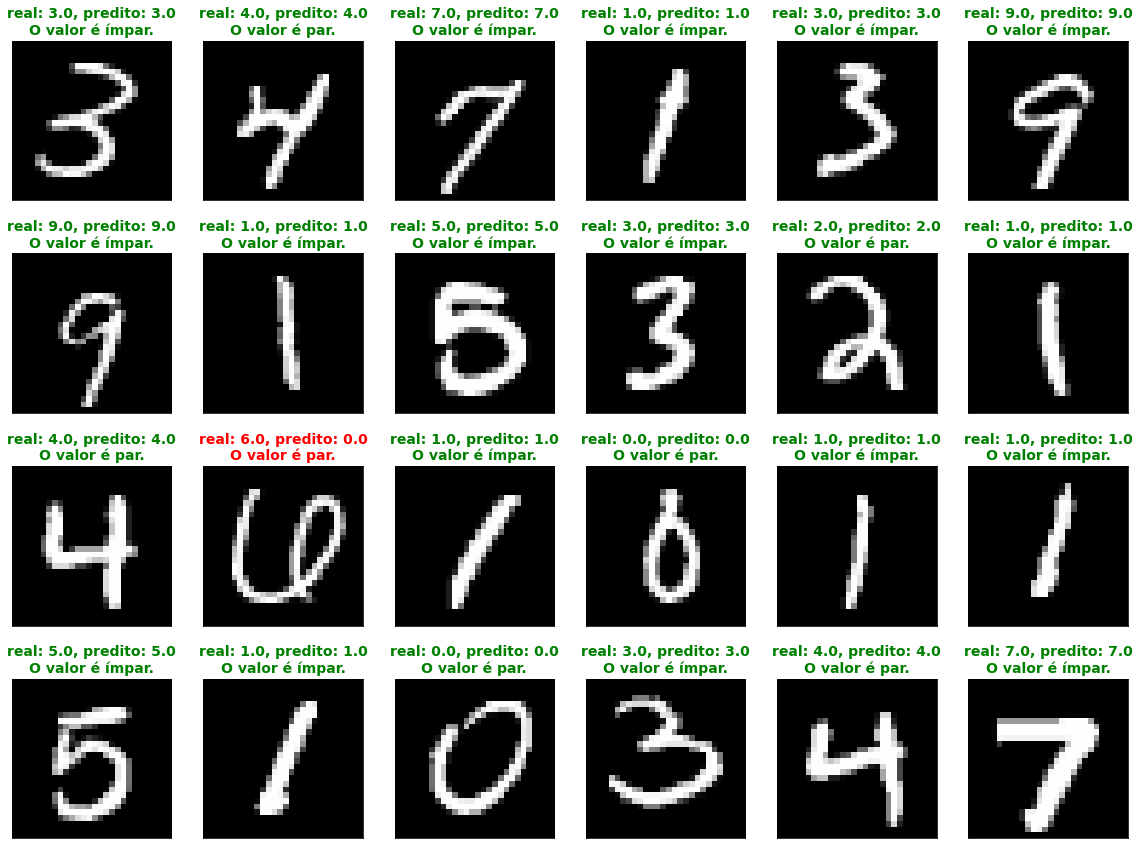

In [14]:
random_idx = np.random.randint(0,Xtest.shape[0], size = 24)

plt.figure(figsize=[20,15])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    xval = Xtest.loc[idx_i, :].values.reshape(28,28)
    ypred = logreg.predict(Xtest)[idx_i]
    yval = ytest[idx_i]
    plt.subplot(4,6,i+1)
    plt.imshow(xval, cmap = plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])
    if (ypred == yval):
        if (ypred % 2 == 0):
            plt.title('real: ' + str(yval) + ', predito: ' + str(ypred) + '\nO valor é par.', fontsize = 14, fontweight = 'bold', color='g')
        else:
            plt.title('real: ' + str(yval) + ', predito: ' + str(ypred) + '\nO valor é ímpar.', fontsize = 14, fontweight = 'bold', color='g')
    else:
        if (yval % 2 == 0):
            plt.title('real: ' + str(yval) + ', predito: ' + str(ypred) + '\nO valor é par.', fontsize = 14, fontweight = 'bold', color='r')
        else:
            plt.title('real: ' + str(yval) + ', predito: ' + str(ypred) + '\nO valor é ímpar.', fontsize = 14, fontweight = 'bold', color='r')
plt.show()

Continuar a solução por esse método seria bastante trabalhoso, uma vez que teríamos que criar uma outra variável para armazenar informações se o número é par ou ímpar para os parâmetros de treino e teste, assim como para os valores preditos. Invés disso, usaremos a Regressão Logística Binária e faremos um tratamento nos valores target antes de treinar o modelo.
Tendo entendido a aplicação e funcionamento do treinamento multiclasse, iniciaremos a solução do problema.

# <span style="color:blue">Solução 2: Regressão Logística Binária</span>

Com isso em meto, realizaremos o tratamento dos dados de treino e de teste. Queremos que o algoritmo faça a predição se o número é par ou ímpar. Para isso, verificaremos se a divisão do valor target por 2 retornará um resto. Ou seja:

Se $y_{target}$ % $2$ == $0$, $y_{target}$ = $1$, caso contrário, $y_{target}$ = $0$.

Dessa forma, o problema se trata de uma regressão logística binária, onde o valor predito, dado que o algoritmo identifique o número, será 0 ou 1.

In [15]:
ytrain_novo = np.where(ytrain % 2 == 0, 1, 0)
ytest_novo = np.where(ytest % 2 == 0, 1, 0)

In [16]:
# Criando uma matriz para verificar a nova variável target (dados de treino)
matriz_comp_target = pd.DataFrame(np.c_[ytrain, ytrain_novo], columns=['y treino', 'Par'])
matriz_comp_target.head(10)

,y treino,Par
0,5.0,0.0
1,0.0,1.0
2,4.0,1.0
3,1.0,0.0
4,9.0,0.0
5,2.0,1.0
6,1.0,0.0
7,3.0,0.0
8,1.0,0.0
9,4.0,1.0


In [17]:
# Criando uma matriz para verificar a nova variável target (dados de teste)
matriz_comp_target = pd.DataFrame(np.c_[ytest, ytest_novo], columns=['y teste', 'Par'])
matriz_comp_target.head(10)

,y teste,Par
0,1.0,0.0
1,2.0,1.0
2,8.0,1.0
3,7.0,0.0
4,4.0,1.0
5,4.0,1.0
6,0.0,1.0
7,9.0,0.0
8,3.0,0.0
9,9.0,0.0


Após a mudança da variável target (0 = número ímpar e 1 = número par), iniciaremos a solução com o modelo de regressão logística.

## Modelo de Regressão Logística

In [18]:
# Treinando a Regressão Logística com as 10 classes
t0 = time.time() # Iniciando contagem do tempo

# Instanciando
logreg_ = LogisticRegression()
logreg_.fit(Xtrain, ytrain_novo)

t1 = time.time() # Finalizando contagem do tempo
dt = t1 - t0
print('O treinamento do modelo de Regressão Logística Binária para prever se um número é par ou ímpar levou %d segundos.' %(dt))

O treinamento do modelo de Regressão Logística Binária para prever se um número é par ou ímpar levou 2 segundos.


Inicialmente já vemos que o treinamento binário levou 3 segundos, enquanto no treinamento multiclasse, o tempo de treinamento foi de 28 segundos.

In [19]:
mat_comp_treino = pd.DataFrame(np.c_[ytrain_novo, logreg_.predict(Xtrain)], columns=['Valor Target', 'Valor Predito'])
mat_comp_treino.head()

,Valor Target,Valor Predito
0,0,0
1,1,1
2,1,1
3,0,0
4,0,0


## Criando a matriz de confusão

In [20]:
# Instanciando o modelo
cm_ = confusion_matrix(y_true = ytrain_novo, y_pred = logreg_.predict(Xtrain))

# Criando um dataframe para visualizar o número de valores preditos para cada dítito.
confusion_mat_ = pd.DataFrame(cm_,
                              columns=['Valor predito ímpar', 'Valor predito par'],
                              index=['Valor real ímpar', 'Valor real par'])
confusion_mat_

,Valor predito ímpar,Valor predito par
Valor real ímpar,25110,2855
Valor real par,2703,24332


A partir desses valores, podemos obter os valores de acurácia, precision, recall e f1 score.

Para facilitar a nossa análise, usaremos as funções de métricas já implementadas no scikit-learn. Com elas, podemos obter o Acurácia, Recall, Precision e F1 score. Abaixo, vemos uma tabela com o valor para cada uma delas.

In [21]:
# Calculando a acurária do modelo manualmente
count = 0
for item1, item2 in zip(mat_comp_treino['Valor Target'].values, mat_comp_treino['Valor Predito'].values):
    if (item1 == item2):
        count += 1

acuracia_manual = round(count/mat_comp_treino.shape[0],4)*100

# Também podemos usar a função accuracy_score:
accuracy_ = round(accuracy_score(y_true = ytrain_novo, y_pred = logreg_.predict(Xtrain)),4)*100

print('Acurácia (manual) é de ', end='')
print(str(acuracia_manual) + ' %')

print('Acurácia (accuracy_score) é de ', end='')
print(str(accuracy_) + ' %')

Acurácia (manual) é de 89.89 %
Acurácia (accuracy_score) é de 89.89 %


In [22]:
recall_ = round(recall_score(y_true = ytrain_novo, y_pred = logreg_.predict(Xtrain)),4)*100
precision_ = round(precision_score(y_true = ytrain_novo, y_pred = logreg_.predict(Xtrain)),4)*100
f1_ = round(f1_score(y_true = ytrain_novo, y_pred = logreg_.predict(Xtrain)),4)*100

df_metricas_f = pd.DataFrame(np.c_[accuracy_, precision_, recall_, f1_], columns=['Acurácia', 'Precision', 'Recall', 'F1'])

def realcarColunas(s):
    return 'background-color: lightgreen'

df_metricas_f.style.applymap(realcarColunas, subset=pd.IndexSlice[:, 'F1'])

,Acurácia,Precision,Recall,F1
0,89.890000,89.500000,90.000000,89.750000


A matriz de confusão nos fornece, no caso de uma classificação binária, A quantidade de __Verdadeiros Negativos (VN = 25110)__, __Verdadeiros Positivos (VP = 24332)__, __Falsos Negativos (FN = 2703)__ e __Falsos Positivos (FP = 2855)__.

Aqui, usaremos o F1 score como métrica de seleção do melhor modelo, uma vez que ele representa a média harmônica entre as métricas precision e recall. Dessa forma, buscaremos o modelo que apresentar o maior valor possível de F1. Com isso em mente, usando o Trade-off entre a Precision e o Recall Score, buscaremos o valor de limiar (threshold) que apresente o maior valor possível para F1.

Exemplo: Se considerarmos um threshold igual a 0,25 (ou 25 %) para todos os valores de probabilidade para a classe 1 obtidos pelo modelo, os que apresentarem a classe 1 com valor maior que 0,25, serão considerados pares (1), enquanto os que apresentarem valores menores, serão considerados ímpares (0). Assim, criaremos uma nova variável para armazenar os valores preditos após aplicar esse filtro.

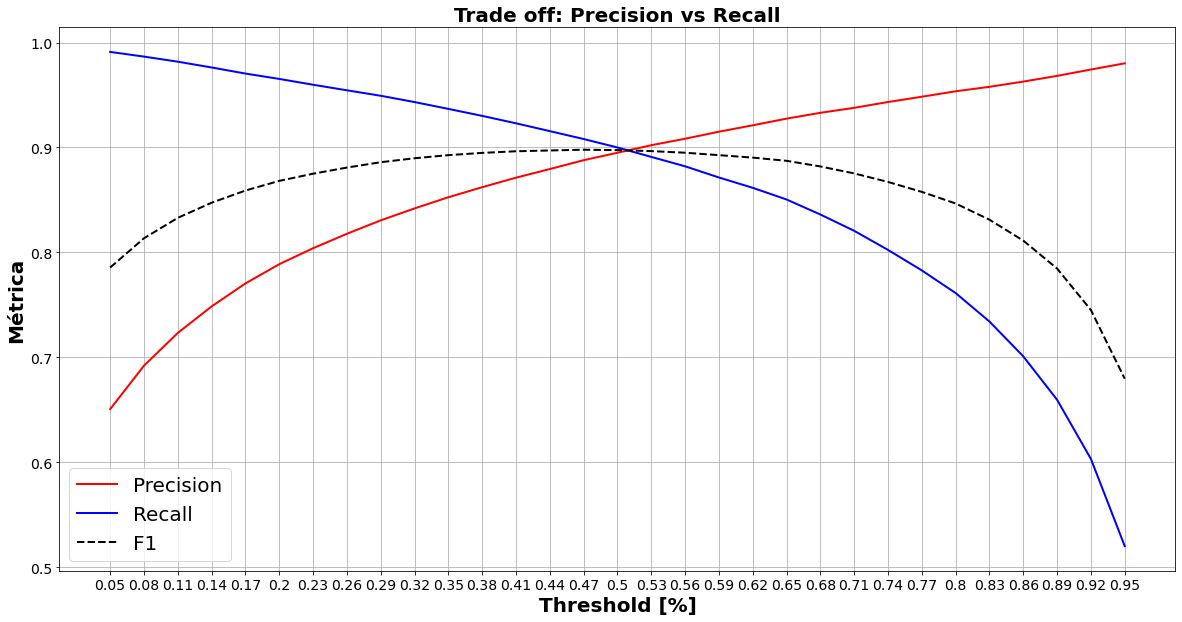

O valor máximo do F1 Score é 89.79 %, quando o threshold é igual a 0.4699999999999999


In [23]:
# Obtendo os valores de probabilidade = 1 para os dados de treino.
prob_1 = logreg_.predict_proba(Xtrain)[:, 1]

# Criando a faixa de limiares a serem testados
threshold = np.linspace(0.05, 0.95, 31)

precision_list = []
recall_list = []
f1_list = []

for t in threshold:
    # Criando nova variável de valores preditos considerando o threshold
    pred_t = np.where(prob_1 > t, 1, 0)
    
    # Calculando Precision Score
    precision_t = precision_score(y_true = ytrain_novo, y_pred = pred_t)
    
    # Calculando Recall Score
    recall_t = recall_score(y_true = ytrain_novo, y_pred = pred_t)
    
    # Calculando F1 Score
    f1_t = f1_score(y_true = ytrain_novo, y_pred = pred_t)
    
    # Adicionando os valores calculados nas listas
    precision_list.append(precision_t)
    recall_list.append(recall_t)
    f1_list.append(f1_t)
    
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), precision_list, c = 'red', label = 'Precision', lw = 2)
plt.plot(range(len(threshold)), recall_list, c = 'blue', label = 'Recall', lw = 2)
plt.plot(range(len(threshold)), f1_list, c = 'black', ls = '--', label = 'F1', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 20)
plt.grid()
plt.xlabel("Threshold [%]", fontsize = 20, fontweight = 'bold')
plt.ylabel("Métrica", fontsize = 20, fontweight = 'bold')
plt.title("Trade off: Precision vs Recall", fontsize = 20, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score é ', end='')
print(str(round(np.max(f1_list),4)*100) + ' %', end=', ')
print('quando o threshold é igual a ', end='')
print(threshold[f1_list.index(np.max(f1_list))])

Após determinar o valor ótimo para o threshold (t = 0,48), aplicaremos o filtro e calcularemos a nova matriz de confusão.

In [24]:
# Aplicando o threshold
t = 0.47
pred_t = np.where(prob_1 > t, 1, 0)

# Instanciando o modelo
cm_ot = confusion_matrix(y_true = ytrain_novo, y_pred = pred_t)

# Criando um dataframe para visualizar o número de valores preditos para cada dítito.
confusion_mat_ot = pd.DataFrame(cm_ot,
                              columns=['Valor predito ímpar', 'Valor predito par'],
                              index=['Valor real ímpar', 'Valor real par'])
confusion_mat_ot

,Valor predito ímpar,Valor predito par
Valor real ímpar,24866,3099
Valor real par,2485,24550


Para efeito de comparação, abaixo temos a matriz antes de aplicar o filtro.

In [25]:
confusion_mat_

,Valor predito ímpar,Valor predito par
Valor real ímpar,25110,2855
Valor real par,2703,24332


Assim como podemos comparar as matrizes com os valores das métricas. Abaixo temos os valores para o threshold = 0.48.

In [26]:
accuracy_ot = round(accuracy_score(y_true = ytrain_novo, y_pred = pred_t),4)*100
recall_ot = round(recall_score(y_true = ytrain_novo, y_pred = pred_t),4)*100
precision_ot = round(precision_score(y_true = ytrain_novo, y_pred = pred_t),4)*100
f1_ot = round(f1_score(y_true = ytrain_novo, y_pred = pred_t),4)*100

df_metricas_ot = pd.DataFrame(np.c_[accuracy_ot, precision_ot, recall_ot, f1_ot], columns=['Acurácia', 'Precision', 'Recall', 'F1'])

def realcarColunas(s):
    return 'background-color: lightgreen'

df_metricas_ot.style.applymap(realcarColunas, subset=pd.IndexSlice[:, 'F1'])


,Acurácia,Precision,Recall,F1
0,89.850000,88.790000,90.810000,89.790000


E os valores considerando o threshold padrão.

In [27]:
df_metricas_f.style.applymap(realcarColunas, subset=pd.IndexSlice[:, 'F1'])

,Acurácia,Precision,Recall,F1
0,89.890000,89.500000,90.000000,89.750000


No caso acima, não foi levada em consideração a validação cruzada. Sendo assim, aplicaremos esse método de validação e verificaremos se o valor ótimo de threshold é realmente o escolhido anteriormente, uma vez que foi levado em consideração apenas os dados de treino.

## Validação cruzada

Usaremos a função definida pelo mentor Fábio de Sales Casula para realizar a validação cruzada.

In [28]:
#adaptação da função validacao_cruzada 
def validacao_cruzada(classificador, 
                      X_data, 
                      y_data, 
                      metrica, 
                      num_folds, 
                      limiar = 0.5, 
                      print_info = False, 
                      nome_metrica = None):
    
    lista_metrica_treino = []
    lista_metrica_validacao = []
    
    kf = KFold(n_splits = num_folds)
    for train_index, val_index in kf.split(X_data, y_data):
        Xtrain_folds = X_data.loc[train_index].values
        ytrain_folds = y_data[train_index]
        Xval_fold = X_data.loc[val_index].values
        yval_fold = y_data[val_index]
        classificador.fit(Xtrain_folds, ytrain_folds)
        
        #alteração nesta parte! agora, primeiro calculamos a probabilidade e na sequência usamos o valor do limiar
        prob_class1_treino = classificador.predict_proba(Xtrain_folds)[:,1]
        prob_class1_validacao = classificador.predict_proba(Xval_fold)[:,1]
        pred_treino = np.where(prob_class1_treino > limiar, 1, 0)
        pred_validacao = np.where(prob_class1_validacao > limiar, 1, 0)
        
        lista_metrica_treino.append(metrica(y_pred = pred_treino, y_true = ytrain_folds))
        lista_metrica_validacao.append(metrica(y_pred = pred_validacao, y_true = yval_fold))
    if print_info:
        print("Métrica: " + nome_metrica)
        print('média treino:', np.mean(lista_metrica_treino))
        print('média validação:', np.mean(lista_metrica_validacao))
    return lista_metrica_treino, lista_metrica_validacao

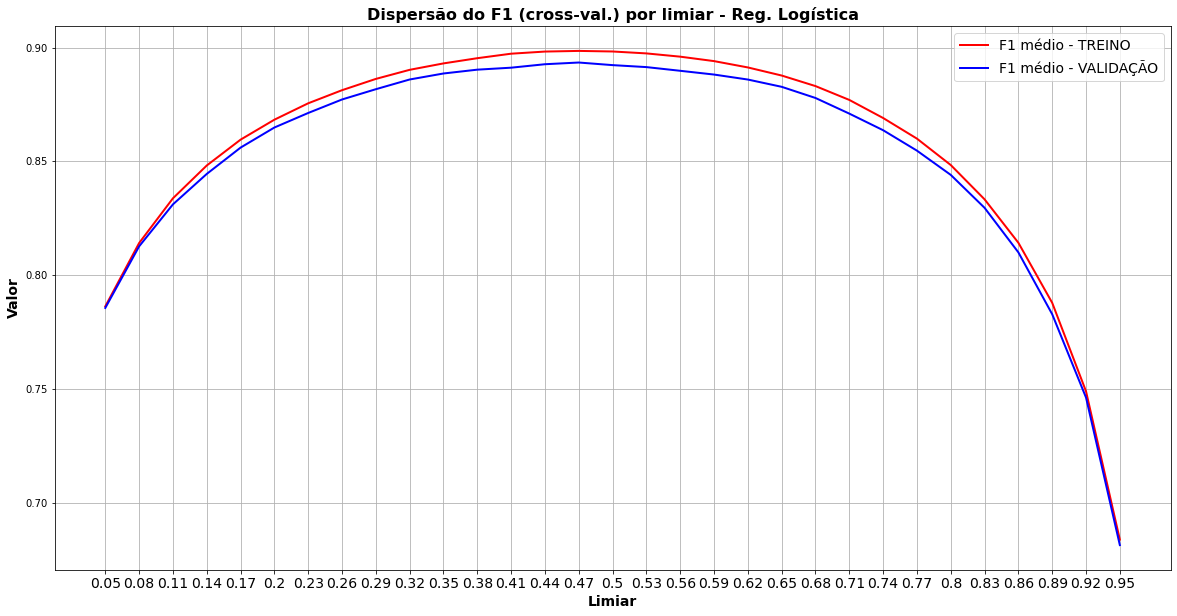

O valor máximo do F1 Score para o treino é 89.86 % para t = 0.4699999999999999

O valor máximo do F1 Score para a validação é 89.35 % para t = 0.4699999999999999

351.97033405303955


In [29]:
lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:
    
    lt, lv = validacao_cruzada(classificador = LogisticRegression(), 
                               X_data = Xtrain, 
                               y_data = ytrain_novo, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - Reg. Logística", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(round(np.max(lista_media_metrica_treino),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(round(np.max(lista_media_metrica_validacao),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

t1 = time.time()
print(t1-t0)

Para o caso apresentado, não vimos diferença no valor do threshold ótimo ( $\approx 0,47$) para o caso da regressão logística. Sendo assim, aplicaremos o modelo so dados de teste e observaremos o resultado das predições.

In [30]:
logreg_ot = LogisticRegression()
logreg_ot.fit(Xtrain, ytrain_novo)
y_pred_teste_prob1 = logreg_ot.predict_proba(Xtest)[:, 1]

# Aplicando o threshold
t = 0.47
pred_t = np.where(y_pred_teste_prob1 > t, 1, 0)

# Instanciando o modelo
cm_teste = confusion_matrix(y_true = ytest_novo, y_pred = pred_t)

# Criando um dataframe para visualizar o número de valores preditos para cada dítito.
confusion_mat_teste = pd.DataFrame(cm_teste,
                              columns=['Valor predito ímpar', 'Valor predito par'],
                              index=['Valor real ímpar', 'Valor real par'])
confusion_mat_teste

,Valor predito ímpar,Valor predito par
Valor real ímpar,6821,796
Valor real par,645,6738


In [31]:
accuracy_ot = round(accuracy_score(y_true = ytest_novo, y_pred = pred_t),4)*100
recall_ot = round(recall_score(y_true = ytest_novo, y_pred = pred_t),4)*100
precision_ot = round(precision_score(y_true = ytest_novo, y_pred = pred_t),4)*100
f1_ot = round(f1_score(y_true = ytest_novo, y_pred = pred_t),4)*100

df_metricas_ot = pd.DataFrame(np.c_[accuracy_ot, precision_ot, recall_ot, f1_ot], columns=['Acurácia', 'Precision', 'Recall', 'F1'])

def realcarColunas(s):
    return 'background-color: lightgreen'

df_metricas_ot.style.applymap(realcarColunas, subset=pd.IndexSlice[:, 'F1'])


,Acurácia,Precision,Recall,F1
0,90.390000,89.430000,91.260000,90.340000


Aplicando o modelo aos dados de teste, obtivemos um valor do F1 Score ainda maior. Vejamos como ele responde visualmente com os número aleatórios abaixo.

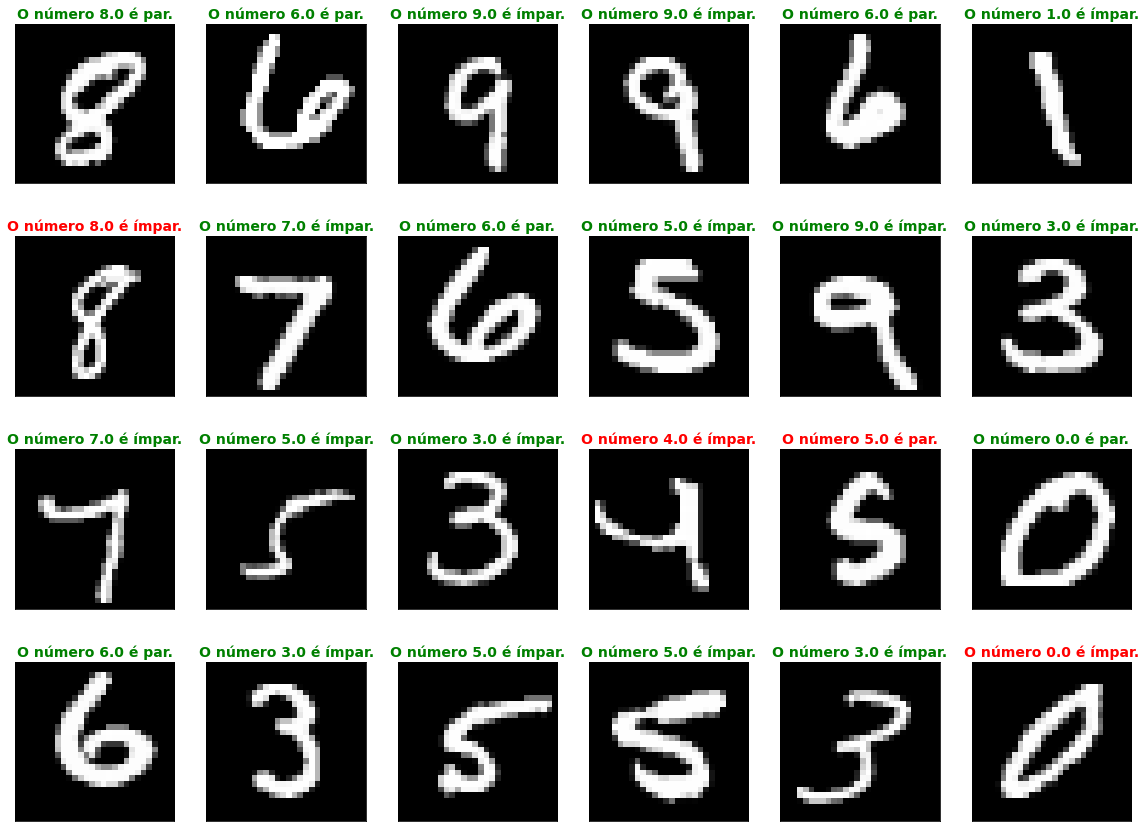

In [32]:
random_idx = np.random.randint(0,Xtest.shape[0], size = 24)

plt.figure(figsize=[20,15])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    num = ytest[idx_i]
    xval = Xtest.loc[idx_i, :].values.reshape(28,28)
    ypred = logreg_ot.predict(Xtest)[idx_i]
    yval = ytest_novo[idx_i]
    plt.subplot(4,6,i+1)
    plt.imshow(xval, cmap = plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])
    if (ypred == 0):
        if (ypred == yval):
            plt.title('O número %s é ímpar.' %(str(num)), fontsize = 14, fontweight = 'bold', color='g')
        else:
            plt.title('O número %s é ímpar.' %(str(num)), fontsize = 14, fontweight = 'bold', color='r')
    else:
        if (ypred == yval):
            plt.title('O número %s é par.' %(str(num)), fontsize = 14, fontweight = 'bold', color='g')
        else:
            plt.title('O número %s é par.' %(str(num)), fontsize = 14, fontweight = 'bold', color='r')

plt.show()

O títulos em verde mostram que quais as predições corretas (se o número é par ou ímpar), enquanto os títulos em vermelho mostram as predições erradas. De uma maneira geral, vemos que a Regressão Logística apresenta uma probabilidade de, aproximadamente, 90 % de conseguir identificar corretamente se um número é par ou ímpar.

## Outras métricas que podem ser consideradas

Uma outra métrica que pode ser usada para avaliar qual modelo se ajusta melhor aos dados é curva ROC (*Receiver Operating Characteristic*). A curva ROC é uma métrica visual e quanto maior for a derivada na região próxima de zero, melhor o ajuste do modelo.

Aplicando aos dados de teste mostrados acima, obtemos a curva ROC, linha sólida azul, abaixo. A linha preta tracejada representa uma classificação aleatória do modelo. Quanto mais afastado da linha preta, melhor a resposta do modelo ajustado.

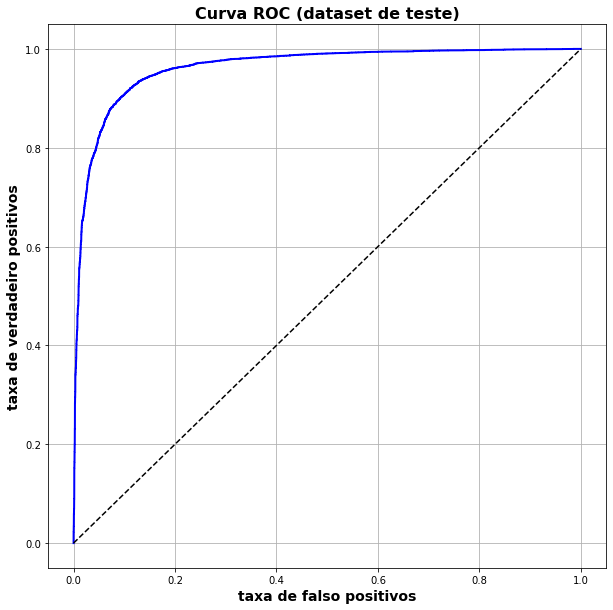

In [33]:
fpr, tpr, thresholds = roc_curve(y_true = ytest_novo, y_score = y_pred_teste_prob1) 

#fpr = false positive rate = taxa de falso positivos
#tpr = true positive rate = taxa de verdadeiro positivos
#thresholds = limiares usados

plt.figure(figsize=[10,10])
plt.plot(fpr, tpr, c = 'blue', lw = 2)
plt.title("Curva ROC (dataset de teste)", fontsize = 16, fontweight = 'bold')
plt.xlabel("taxa de falso positivos", fontsize = 14, fontweight = 'bold')
plt.ylabel("taxa de verdadeiro positivos", fontsize = 14, fontweight = 'bold')
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
plt.grid()
plt.show()

Integrando a curva acima, obtemos o valor da AUC-ROC (*Area Under Curve - ROC*), na qual o valor máximo é 1 (área do quadrado com lado igual a 1). Logo, quanto mais próximo de 1, melhor o ajuste. Essa técnica pode ser implementada e comparada junto às outras vistas anteriormente (acurácia, precision, recall e f1 score).

In [34]:
auc_teste = roc_auc_score(y_true = ytest_novo, y_score = y_pred_teste_prob1)
print('O valor da AUC-ROC é de ', end='')
print(auc_teste)

O valor da AUC-ROC é de 0.9623708247861422


# <span style="color:blue">Solução 3: K-Nearest Neighbors para classificação</span>

Partiremos da função "validacao_cruzada" e aplicaremos o modelo KNN-Classifier. Para esse modelo, deve-se especificar o hiperparâmetro conhecido como número de vizinhos. Além disso, iremos determinar o valor ótimo de threshold para o mesmo.

Para realizar a validação cruzada, consideraremos o número de vizinhos iguais a 1, 3, 5, 15 e 50 e iremos avaliar qual obteve a melhor resposta em função da métrica adotada (F1 Score). Ainda, valores muito pequenos (próximo de 0) e valores muito altos (próximo de 1) de threshold fazem com que a métrica F1 score diminua. Com isso em mente, e pensando no desempenho, iremos limitar o threshold para a seguinte faixa: 0.25 < t < 0.75. Para a validação cruzada, consideraremos 5 dobras (folds).

### KNN-Classifier: K = 1

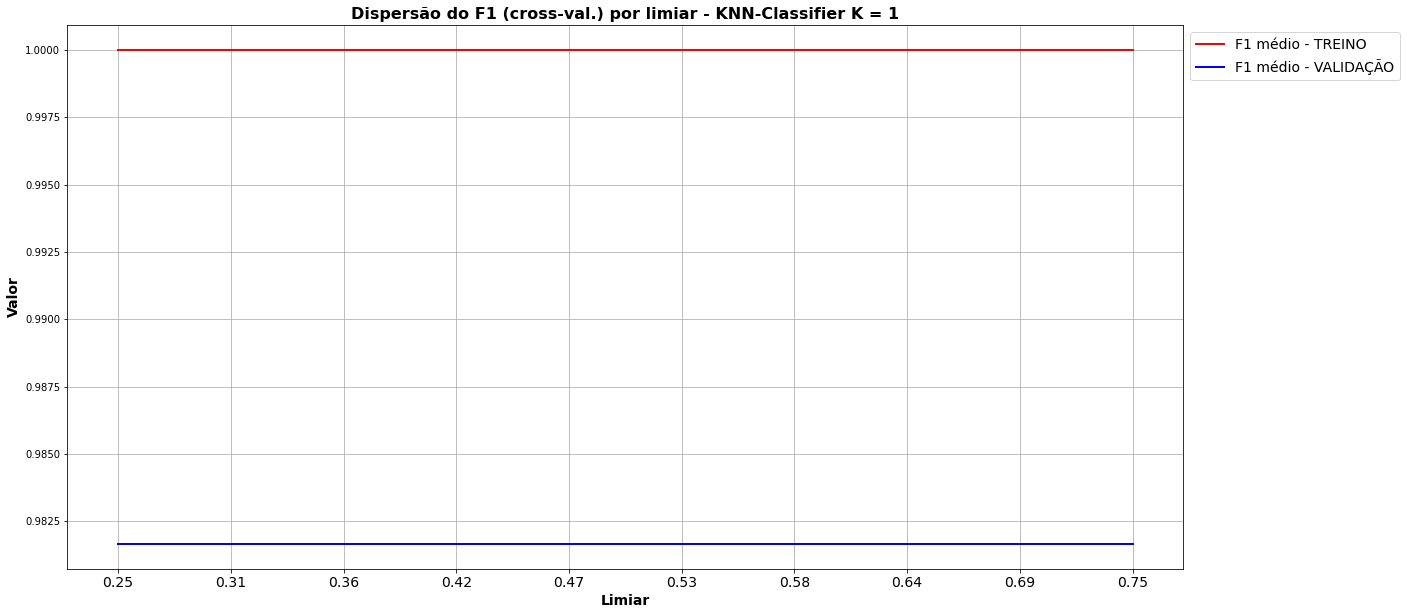

O valor máximo do F1 Score para o treino é 100.0 % para t = 0.25

O valor máximo do F1 Score para a validação é 98.17 % para t = 0.25

O tempo de execução foi de 1731 segundos.


In [36]:
lista_viz = [1, 3, 5, 15, 50]
lista_treino = []
lista_validacao = []
lista_thr = []

# Criando a faixa de limiares a serem testados
threshold = np.linspace(0.25, 0.75, 10)

lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:

    lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=1), 
                               X_data = Xtrain, 
                               y_data = ytrain_novo, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - KNN-Classifier K = 1", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(round(np.max(lista_media_metrica_treino),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(round(np.max(lista_media_metrica_validacao),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

lista_treino.append(np.max(lista_media_metrica_treino))
lista_validacao.append(np.max(lista_media_metrica_validacao))
lista_thr.append(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))])
                    
t1 = time.time()
dt = t1 - t0
print('O tempo de execução foi de %d segundos.' %(dt))

### KNN-Classifier: K = 3

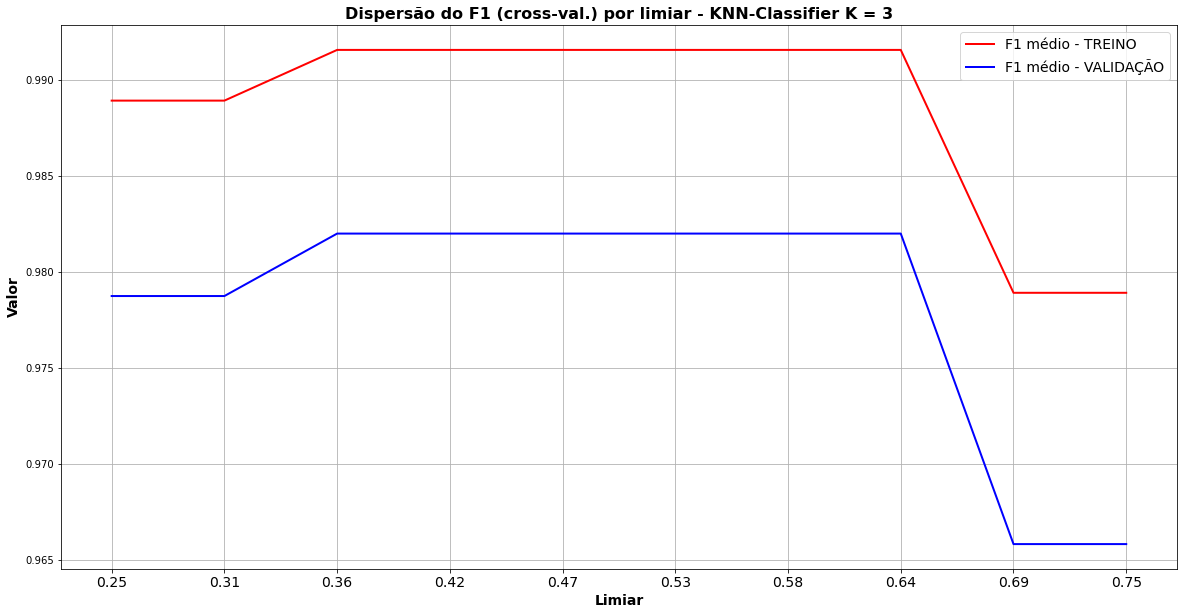

O valor máximo do F1 Score para o treino é 99.15 % para t = 0.3611111111111111

O valor máximo do F1 Score para a validação é 98.2 % para t = 0.3611111111111111

O tempo de execução foi de 1945 segundos.


In [37]:
lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:

    lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=3), 
                               X_data = Xtrain, 
                               y_data = ytrain_novo, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - KNN-Classifier K = 3", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(round(np.max(lista_media_metrica_treino),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(round(np.max(lista_media_metrica_validacao),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

lista_treino.append(np.max(lista_media_metrica_treino))
lista_validacao.append(np.max(lista_media_metrica_validacao))
lista_thr.append(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))])

t1 = time.time()
dt = t1 - t0
print('O tempo de execução foi de %d segundos.' %(dt))

### KNN-Classifier: K = 5

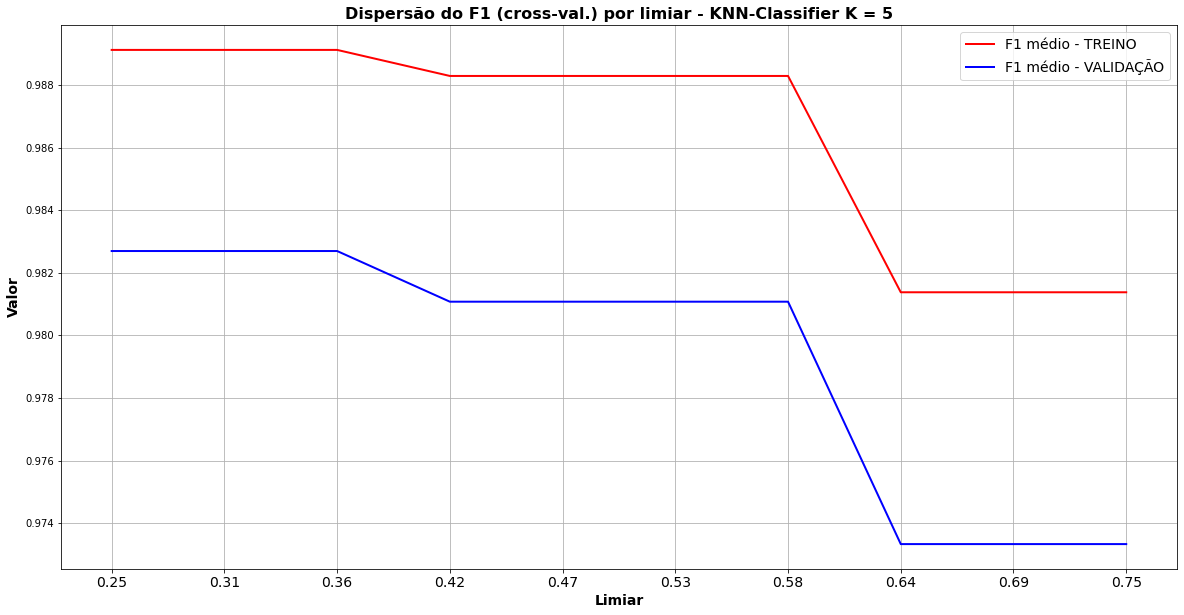

O valor máximo do F1 Score para o treino é 98.91 % para t = 0.25

O valor máximo do F1 Score para a validação é 98.27 % para t = 0.25

O tempo de execução foi de 2355 segundos.


In [38]:
lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:

    lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=5), 
                               X_data = Xtrain, 
                               y_data = ytrain_novo, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - KNN-Classifier K = 5", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(round(np.max(lista_media_metrica_treino),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(round(np.max(lista_media_metrica_validacao),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

lista_treino.append(np.max(lista_media_metrica_treino))
lista_validacao.append(np.max(lista_media_metrica_validacao))
lista_thr.append(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))])

t1 = time.time()
dt = t1 - t0
print('O tempo de execução foi de %d segundos.' %(dt))

### KNN-Classifier: K = 15

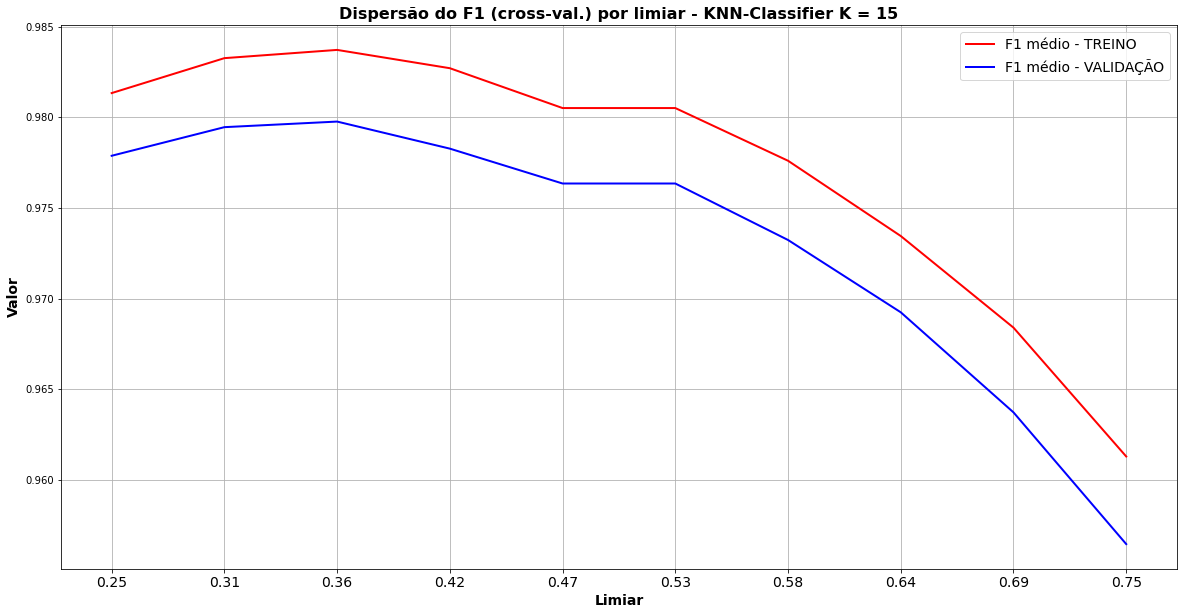

O valor máximo do F1 Score para o treino é 98.37 % para t = 0.3611111111111111

O valor máximo do F1 Score para a validação é 97.98 % para t = 0.3611111111111111

O tempo de execução foi de 2357 segundos.


In [39]:
lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:

    lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=15), 
                               X_data = Xtrain, 
                               y_data = ytrain_novo, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - KNN-Classifier K = 15", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(round(np.max(lista_media_metrica_treino),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(round(np.max(lista_media_metrica_validacao),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

lista_treino.append(np.max(lista_media_metrica_treino))
lista_validacao.append(np.max(lista_media_metrica_validacao))
lista_thr.append(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))])

t1 = time.time()
dt = t1 - t0
print('O tempo de execução foi de %d segundos.' %(dt))

### KNN-Classifier: K = 50

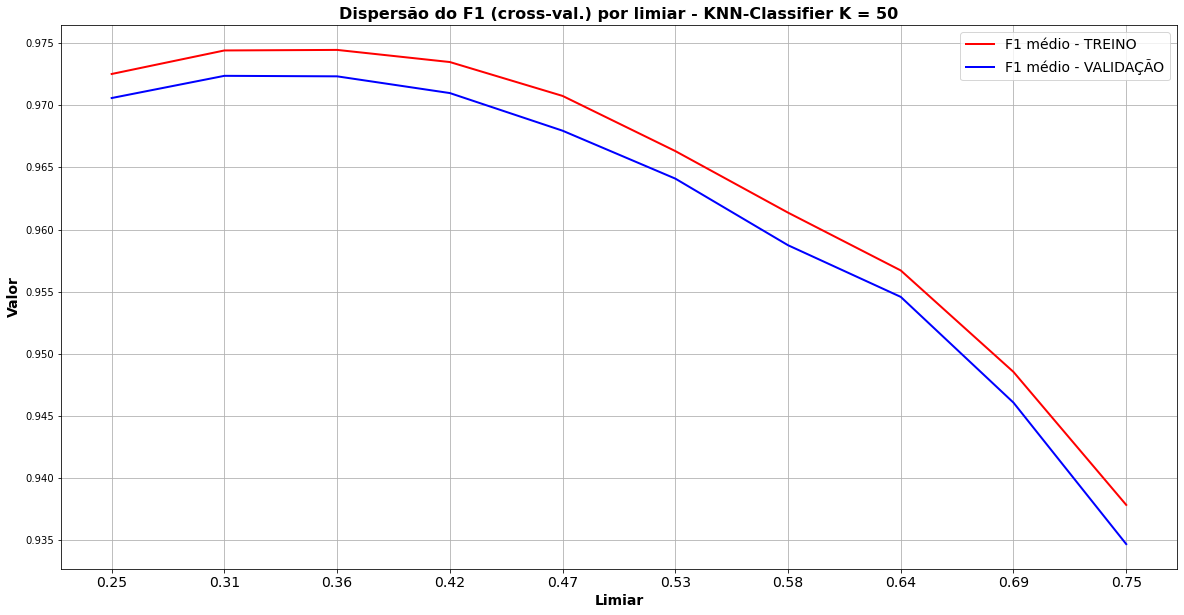

O valor máximo do F1 Score para o treino é 97.45 % para t = 0.3611111111111111

O valor máximo do F1 Score para a validação é 97.24000000000001 % para t = 0.3055555555555556

O tempo de execução foi de 2488 segundos.


In [40]:
lista_media_metrica_treino = []
lista_media_metrica_validacao = []

t0 = time.time()

for t in threshold:

    lt, lv = validacao_cruzada(classificador = KNeighborsClassifier(n_neighbors=50), 
                               X_data = Xtrain, 
                               y_data = ytrain_novo, 
                               metrica = f1_score,
                               num_folds = 5, 
                               limiar = t)
    
    lista_media_metrica_treino.append(np.mean(lt))
    lista_media_metrica_validacao.append(np.mean(lv))
    
plt.figure(figsize=[20,10])
plt.plot(range(len(threshold)), lista_media_metrica_treino, c = 'red', label = 'F1 médio - TREINO', lw = 2)
plt.plot(range(len(threshold)), lista_media_metrica_validacao, c = 'blue', label = 'F1 médio - VALIDAÇÃO', lw = 2)
plt.xticks(range(len(threshold)), threshold.round(2), fontsize = 14)
plt.legend(fontsize = 14, bbox_to_anchor = [1,1])
plt.grid()
plt.xlabel("Limiar", fontsize = 14, fontweight = 'bold')
plt.ylabel("Valor", fontsize = 14, fontweight = 'bold')
plt.title("Dispersão do F1 (cross-val.) por limiar - KNN-Classifier K = 50", fontsize = 16, fontweight = 'bold')
plt.show()

print('O valor máximo do F1 Score para o treino é ', end='')
print(str(round(np.max(lista_media_metrica_treino),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_treino.index(np.max(lista_media_metrica_treino))], end='\n\n')

print('O valor máximo do F1 Score para a validação é ', end='')
print(str(round(np.max(lista_media_metrica_validacao),4)*100) + ' %', end=' ')
print('para t = ', end='')
print(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))], end='\n\n')

lista_treino.append(np.max(lista_media_metrica_treino))
lista_validacao.append(np.max(lista_media_metrica_validacao))
lista_thr.append(threshold[lista_media_metrica_validacao.index(np.max(lista_media_metrica_validacao))])

t1 = time.time()
dt = t1 - t0
print('O tempo de execução foi de %d segundos.' %(dt))

In [43]:
# Criando uma tabela para comparar os resultados obtidos nos processamentos acima
df_knn_met = pd.DataFrame(np.c_[lista_viz, lista_treino, lista_validacao, lista_thr], columns=['K', 'F1 treino', 'F1 validação', 'Threshold'])
df_knn_met['Dif. ponto percent.'] = df_knn_met['F1 treino'].values - df_knn_met['F1 validação'].values

df_knn_met

,K,F1 treino,F1 validação,Threshold,Dif. ponto percent.
0,1.0,1.000000,0.981651,0.250000,0.018349
1,3.0,0.991540,0.981990,0.361111,0.009550
2,5.0,0.989130,0.982699,0.250000,0.006431
3,15.0,0.983722,0.979771,0.361111,0.003951
4,50.0,0.974461,0.972374,0.305556,0.002087


Para escolhermos o modelo, levaremos em consideração o que apresentar a menor diferença em os F1 score de treino e o de validação. Pela tabela acima, vemos que o que apresentou menor diferença foi modelo KNN com K = 50. Sendo assim, iremos utilizá-lo para realizar a predição dos dados de teste.

In [44]:
# Instanciando o modelo KNN-Classifier com K = 50
knn_ = KNeighborsClassifier(n_neighbors=50)
knn_.fit(Xtrain, ytrain_novo)

ypred_prob_knn = knn_.predict_proba(Xtest)[:, 1]
pred_t_knn = np.where(ypred_prob_knn > 0.306, 1, 0)

# F1 Score - dados de teste
f1_ot = round(f1_score(y_true = ytest_novo, y_pred = pred_t_knn),4)*100
print('O F1 score para os dados de teste é %s' %(str(f1_ot)))

O F1 score para os dados de teste é 98.00999999999999


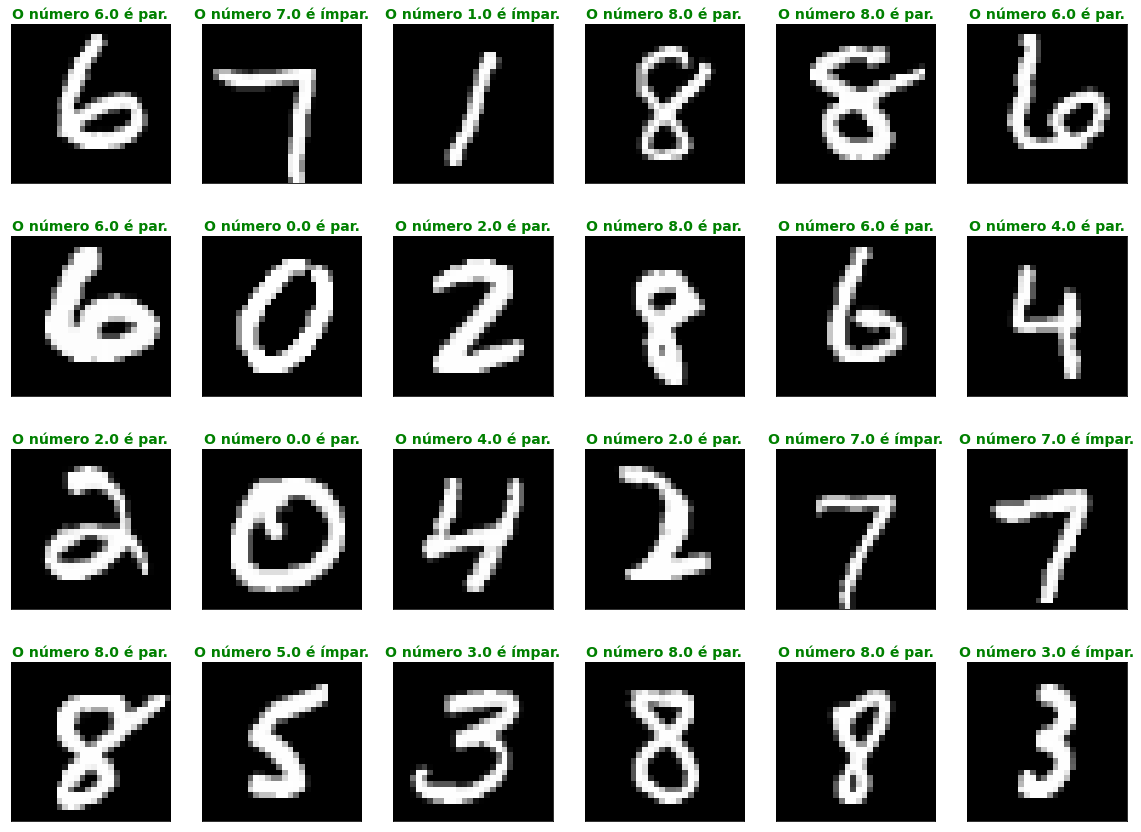

In [46]:
random_idx = np.random.randint(0,Xtest.shape[0], size = 24)

plt.figure(figsize=[20,15])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    num = ytest[idx_i]
    xval = Xtest.loc[idx_i, :].values.reshape(28,28)
    ypred = pred_t_knn[idx_i]
    yval = ytest_novo[idx_i]
    plt.subplot(4,6,i+1)
    plt.imshow(xval, cmap = plt.cm.Greys_r)
    plt.xticks([])
    plt.yticks([])
    if (ypred == 0):
        if (ypred == yval):
            plt.title('O número %s é ímpar.' %(str(num)), fontsize = 14, fontweight = 'bold', color='g')
        else:
            plt.title('O número %s é ímpar.' %(str(num)), fontsize = 14, fontweight = 'bold', color='r')
    else:
        if (ypred == yval):
            plt.title('O número %s é par.' %(str(num)), fontsize = 14, fontweight = 'bold', color='g')
        else:
            plt.title('O número %s é par.' %(str(num)), fontsize = 14, fontweight = 'bold', color='r')

plt.show()

## Conclusão

Considerando a métrica F1 score, o algoritmo KNN-Classifier com K = 50 se mostrou superior ao de Regressão Logística. O valor de F1 score para o modelo KNN, nos dados de teste, alcançou um valor igual a 98,01%, enquanto para o algoritmo de Regressão logistica foi de apenas 90,4%.

Para o modelo KNN-Classifier, a medida que o número de vizinhos aumenta, o valor da métrica adotada diminui. Entretanto, caso seja considerada a diferença em pontos percentuais entre elas, como no caso acima, vemos que o aumento no número de vizinhos gera uma maior precisão para a classificação.

Um outro ponto que deve-se ter atenção é o tempo para otimizar o modelo. Enquanto os modelos KNN apresentaram tempos entre 32 e 42 minutos para determinar o melhor valor de threshold para os números de vizinhos testados, o modelo de Regressão Logística Binária levou apenas 6 minutos.